# Assignment 10

Consider the reservoir shown below with the given properties that has been discretized into 4 equal grid blocks.

![image](images/grid.png)

Below is a skeleton of a Python class that can be used to solve for the pressures in the reservoir.  The class is actually written generally enough that it can account for an arbitrary number of grid blocks, but we will only test cases with 4.  The class takes a Python dictionary (which can be read from a YAML formatted file) of input parameters as an initialization argument.  An example of a complete set of input parameters is shown in the `input.yml` file included in the repository.

Several simple useful functions are already implemented, your task is to implement the functions `fill_matrices()` and `solve_one_step()`.  `fill_matrices()` should correctly populate the $A$, $I$ matrices as well as the vector $\vec{p}_B$.  These should also correctly account for the application of boundary conditions.  Only the boundary conditions shown in the figure will be tested, but in preparation for future assignments, you may wish to add the logic to the code such that arbitrary pressure/no flow boundary conditions can be applied to either side of the one-dimensional reservoir. `solve_one_step()` should solve a single time step for either the explicit or implicit methods depending on which is specified in the input parameters. The $\vec{p}{}^{n+1}$ values should be stored in the class attribute `self.p`.  For the implicit solves, use `scipy.sparse.lingalg.cg` with `atol=1.0e-8` to solve the linear system of equations.  If this is implemented correctly, you will be able to then use the `solve()` function to solve the problem up to the `'number of time steps'` value in the input parameters.

Once you have the tests passing, you might like to experiment with viewing several plots with different time steps, explicit vs. implicit, number of grid blocks, etc.  To assist in giving you a feel for how they change the character of the approximate solution.  I have implemented a simple plot function that might help for this.

In [67]:
import yaml
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

In [68]:
class OneDimReservoir():
    
    def __init__(self, inputs):
        '''
            Class for solving one-dimensional reservoir problems with
            finite differences.
        '''
        
        #stores input dictionary as class attribute, either read from a yaml file
        #or directly from a Python dictonary
        if isinstance(inputs, str):
            with open(inputs) as f:
                self.inputs = yaml.load(f, yaml.FullLoader)
        else:
            self.inputs = inputs
        
        #computes delta_x
        self.Nx = self.inputs['numerical']['number of grids']['x']
        self.N = self.Nx
        self.delta_x = self.inputs['reservoir']['length'] / float(self.Nx)
        
        #gets delta_t from inputs
        self.delta_t = self.inputs['numerical']['time step']
        
        #applies the initial reservoir pressues to self.p
        self.apply_initial_conditions()
        
        #calls fill matrix method (must be completely implemented to work)
        self.fill_matrices()
        
        #create an empty list for storing data if plots are requested
        if 'plots' in self.inputs:
            self.p_plot = []
            
        return
    
    def compute_eta(self):
        '''
        Computes transmissibility.
        T = (k / (mu * B)) * (A / dx)
        '''
        k   = self.inputs['reservoir']['permeability']
        mu  = self.inputs['fluid']['water']['viscosity']
        Bw  = 1.0 #self.inputs['fluid']['water']['formation volume factor']
        A   = 1000 #self.inputs['reservoir']['cross sectional area']
        dx  = self.delta_x
        eta = 2*(k / (mu * Bw)) * (A / dx) * self.inputs['conversion factor'] 
        return eta
    
    def compute_transmissibility(self):
        '''
        Computes transmissibility.
        T = (k / (mu * B)) * (A / dx)
        '''
        k   = self.inputs['reservoir']['permeability']
        mu  = self.inputs['fluid']['water']['viscosity']
        Bw  = 1.0 #self.inputs['fluid']['water']['formation volume factor']
        A   = 1.0 #self.inputs['reservoir']['cross sectional area']
        dx  = self.delta_x

        return (k / (mu * Bw)) * (A / dx)
    
    def compute_accumulation(self):
        '''
        Computes accumulation coefficient.
        B = phi * c_t * V / dt
        '''
        phi = self.inputs['reservoir']['porosity']
        c_t = self.inputs['fluid']['water']['compressibility']
        A = 1.0 #self.inputs['reservoir']['cross sectional area']
        dx = self.delta_x
        V = A * dx
        return phi * c_t * V / self.delta_t
    

    def fill_matrices(self):
        """
        Build sparse T, B, and source Q.
        Use Teff = transmissibility * conversion_factor in the matrices.
        Handle BCs as ghost-cell sources (Dirichlet via ghost cell on left, flux on right).
        """
        N    = self.N
        T0   = self.compute_transmissibility()
        self.eta = self.compute_eta()                     
        conv = self.inputs['conversion factor']                    
        Teff = T0 * conv                                           

        Bval = self.compute_accumulation()                         

        self.T = scipy.sparse.lil_matrix((N, N))
        self.B = scipy.sparse.lil_matrix((N, N))
        self.Q = np.zeros(N)

        # Accumulation on ALL rows
        for i in range(N):
            self.B[i, i] = Bval

        # Symmetric 1D transmissibility (interior)
        for i in range(N):
            if i > 0:
                self.T[i, i]   += Teff
                self.T[i, i-1] -= Teff
            if i < N-1:
                self.T[i, i]   += Teff
                self.T[i, i+1] -= Teff

        # Boundary conditions:
        left  = self.inputs['boundary conditions']['left']
        right = self.inputs['boundary conditions']['right']

        # LEFT prescribed pressure via ghost cell
        if left['type'] == 'prescribed pressure':
            Pleft = left['value']
            # Overwrite row 0 with ghost-cell stencil
            self.T[0, :] = 0
            self.T[0, 0] = 3.0 * Teff
            if N > 1:
                self.T[0, 1] = -1.0 * Teff
            # Keep B[0,0] as Bval (don’t zero it)
            self.Q[0] += 2.0 * Teff * Pleft

        # RIGHT prescribed flux
        if right['type'] == 'prescribed flux':
            qright = right['value']
            self.Q[-1] += qright

        self.T = self.T.tocsc()
        self.B = self.B.tocsc()
        

    def apply_initial_conditions(self):
        '''
        Applies initial reservoir pressures.
        '''
        N = self.N
        self.p = np.ones(N) * self.inputs['initial conditions']['pressure']
        

    def solve_one_step(self):
        solver = self.inputs['numerical'].get('solver', 'implicit').lower()

        if solver == 'explicit':
            # p^{n+1} = p^n + B^{-1} ( -T p^n + Q )
            rhs = - (self.T @ self.p) + self.Q
            Bdiag = self.B.diagonal()
            dp = np.zeros_like(self.p)
            nz = Bdiag != 0
            dp[nz] = rhs[nz] / Bdiag[nz]
            # (If any Bdiag were zero—which we avoid now—those rows wouldn’t update.)
            self.p = self.p + dp

        elif solver == 'implicit':
            # (B + T) p^{n+1} = B p^n + Q
            A   = self.B + self.T
            rhs = (self.B @ self.p) + self.Q
            p_new, info = scipy.sparse.linalg.cg(A, rhs, atol=1e-8, maxiter=1000)
            if info != 0:
                # fallback for robustness
                from scipy.sparse.linalg import spsolve
                p_new = spsolve(A, rhs)
            self.p = p_new

        else:
            raise ValueError(f"Unknown solver: {solver}")
    

    def solve(self):
        '''
        Run simulation for specified number of time steps.
        '''
        for i in range(self.inputs['numerical']['number of time steps']):
            self.solve_one_step()
            if 'plots' in self.inputs and i % self.inputs['plots']['frequency'] == 0:
                self.p_plot += [self.get_solution()]
    

    def plot(self):
        '''
        Simple plotting function.
        '''
        if hasattr(self, "p_plot") and self.p_plot is not None:
            for i in range(len(self.p_plot)):
                plt.plot(self.p_plot[i])
    

    def get_solution(self):
        '''
        Return current solution vector.
        '''
        return self.p

# Example code execution

If you'd like to run your code in the notebook, perhaps creating a crude plot of the output, you can uncomment the following lines of code in the cell below.  You can also inspect the contents of `inputs.yml` and change the parameters to see how the solution is affected.

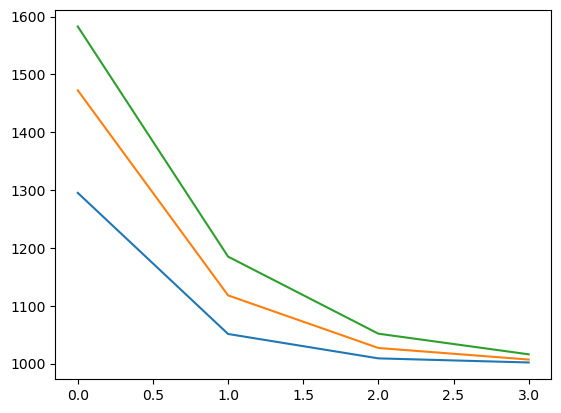

In [69]:
implicit = OneDimReservoir('inputs.yml')
implicit.solve()
implicit.plot()